## Discretizando variables numéricas

Discretización es el proceso de transformar las variables numéricas en variables discretas creando un conjunto de intervalos o segmentos continuos que abarcan todo el rango de la variable transformada. Los segmentos también se conocen como bins o buckets, de ahí que al proceso de discretizar se le conozca como 'binning' en inglés.  


### Discretización ayuda con el manejo de valores extremos y mejora la distribución de las variables sesgadas.

La discretización mitiga el efecto de los valores extremos colocándolos en los intervalos inferiores o superiores, junto con el resto de los valores cercanos en la distribución. Por lo tanto, estos valores extremos ya no son diferentes de los otros y hacen parte del mismo intervalo o bucket. Además, si los segmentos o bins son seleccionados apropiadamente, discretización puede ayudar a escalar las variables sesgadas en un conjunto de intervalos con una mejor distribución


### Criterios de segmentación/discretización

Hay varios métodos para transformar las variables continuas en variables discretas, y en general se pueden dividir en dos categorías: **supervisados y sin supervisión**. Los métodos sin supervisión no usan ninguna información aparte de la distribución de la variable para crear los segmentos continuos en los cuales los valores van a ser ubicados. Los métodos supervisados típicamente usan la información del target para construir los intervalos o bins.


####  Métodos de discretización sin supervisión (unsupervised en inglés)

Los criterios de segmentación más comunes son:

- Igual rango
- Igual frecuencia
- K-medias

####  Métodos de discretización supervisados

- Usando árboles de decisión

En esta clase vamos a presentar **discretización en intervalos de igual rango**.


## Discretización en intervalos de Igual rango

La discretización en intervalos de igual rango, divide los posibles valores de una variable en N segmentos del mismo tamaño/ancho. El tamaño es determinado por el rango de valores presente en la variable y el número de segmentos en los que se quiere dividir la misma.

ancho = (max valor - min valor) / N

donde N es en número de segmentos o intervalos (bins).

Por ejemplo si los valores de la variable varían entre 0 y 100, creamos 5 segmentos así: ancho = (100-0) / 5 = 20. Los segmentos son entonces 0-20, 20-40, 40-60, 80-100. El primer y el último segmento pueden ser expandido to acomodar valores extremos (valores que están por debajo de 0 o encima de 100 pueden ser contenidos en estos segmentos).

No hay una regla para definir el número N de segmentos, esto es algo que se debe determinar probando diferentes valores. 

Dado que el rango se suele seleccionar de los histogramas que muestran la distribución de cada variable, esta técnica es altamente susceptible a los valores atípicos.


## En este demo

Vamos a aprender como discretizar variables utilizando el método de segmentos de igual rango usando los datos del Titanic

- pandas y NumPy
- Feature-engine
- Scikit-learn


In [34]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import KBinsDiscretizer

from feature_engine.discretisation import EqualWidthDiscretiser

In [35]:
# cargar variables numéricas Titanic Dataset

data = pd.read_csv('../titanic.csv',
                   usecols=['age', 'fare', 'survived'])

data.head()

,survived,age,fare
0,1,29.0000,211.3375
1,1,0.9167,151.5500
2,0,2.0000,151.5500
3,0,30.0000,151.5500
4,0,25.0000,151.5500


In [36]:
# separemos sets entrenamiento y prueba 

X_train, X_test, y_train, y_test = train_test_split(
    data[['age', 'fare']],
    data['survived'],
    test_size=0.3,
    random_state=0)

X_train.shape, X_test.shape

((916, 2), (393, 2))

Las variables age y fare contienen datos faltantes. Los vamos a completar extrayendo una muestra aleatoria de la variable.

In [37]:
def impute_na(data, variable):
    
    # función para reemplazar NA con una muestra aleatoria

    df = data.copy()

    # muestra aleatoria
    df[variable+'_aleatoria'] = df[variable]

     # extraer muestra aleatoria para completar datos faltantes na
    random_sample = X_train[variable].dropna().sample(
        df[variable].isnull().sum(), random_state=0)

    # pandas necesita tener el mismo index para poder 
    # combinar los dataframes
    random_sample.index = df[df[variable].isnull()].index
    df.loc[df[variable].isnull(), variable+'_aleatoria'] = random_sample

    return df[variable+'_aleatoria']

In [38]:
# reemplazar los NA en sets de entrenamiento y prueba
X_train['age'] = impute_na(data, 'age')
X_test['age'] = impute_na(data, 'age')

X_train['fare'] = impute_na(data, 'fare')
X_test['fare'] = impute_na(data, 'fare')

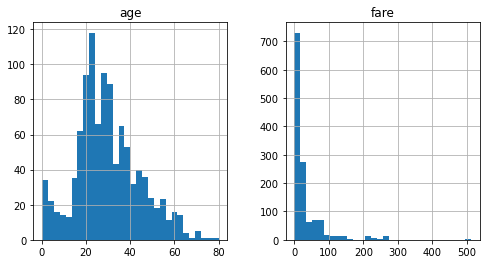

In [39]:
# exploremos la distribución de la variable age

data[['age', 'fare']].hist(bins=30, figsize=(8,4))
plt.show()

## Discretización igual rango con pandas y NumPy

Primero miremos el rango de valores de la variable para estimar al tamaño de cada uno de los intervalos:

In [40]:
# capturemos el rango de la variable age 
age_range = X_train['age'].max() - X_train['age'].min()

age_range

73.8333

In [41]:
# dividamos el rango en 10 intervalos iguales

age_range / 10

7.383329999999999

El rango o ancho de nuestros intervalos será de 7 años.

Ahora podemos estimar los límites de cada uno de los intervalos

In [42]:
# ahora capturemos los límites inferior y superior 
min_value = int(np.floor( X_train['age'].min()))
max_value = int(np.ceil( X_train['age'].max()))

# aproximemos el rango de los intervalos
inter_value = int(np.round(age_range / 10))

min_value, max_value, inter_value

(0, 74, 7)

In [43]:
# capturemos los límites de los intervalos, así podemos pasarlos a
# la función que genera los intervalos

intervals = [i for i in range(min_value, max_value+inter_value, inter_value)]

intervals

[0, 7, 14, 21, 28, 35, 42, 49, 56, 63, 70, 77]

In [44]:
# creemos las etiquetas para cada intervalos

labels = ['Intervalo_' + str(i) for i in range(1, len(intervals))]

labels

['Intervalo_1',
 'Intervalo_2',
 'Intervalo_3',
 'Intervalo_4',
 'Intervalo_5',
 'Intervalo_6',
 'Intervalo_7',
 'Intervalo_8',
 'Intervalo_9',
 'Intervalo_10',
 'Intervalo_11']

In [45]:
# Discreticemos la variable age

# creemos una columna con las etiquetas
X_train['age_disc_etiquetas'] = pd.cut(x=X_train['age'],
                                    bins=intervals,
                                    labels=labels,
                                    include_lowest=True)

# y una con los límites de los intervalos
X_train['age_disc'] = pd.cut(x=X_train['age'],
                             bins=intervals,
                             include_lowest=True)

X_train.head()

,age,fare,age_disc_etiquetas,age_disc
501,13.0,19.5000,Intervalo_2,"(7.0, 14.0]"
588,4.0,23.0000,Intervalo_1,"(-0.001, 7.0]"
402,30.0,13.8583,Intervalo_5,"(28.0, 35.0]"
1193,21.0,7.7250,Intervalo_3,"(14.0, 21.0]"
686,22.0,7.7250,Intervalo_4,"(21.0, 28.0]"


Podemos ver que en el resultado anterior que al discretizar usando intervalos con el mismo rango, colocamos cada observación en la variable age en un intervalo.
Por ejemplo, el valor 23 fué colocado en el intervalo 7-14, mientras que el valor 30 fue colocado en el intervalo 28-35. 

Cuando discretizamos variables utilizando el mismo rango, garantizamos que todos los intervalos tienen el mismo tamaño, sin embargo, esto no significa que van a tener el mismo número de observaciones. Veamos a continuación:

In [46]:
X_train.groupby('age_disc')['age'].count()

age_disc
(-0.001, 7.0]     48
(7.0, 14.0]       31
(14.0, 21.0]     155
(21.0, 28.0]     230
(28.0, 35.0]     176
(35.0, 42.0]     105
(42.0, 49.0]      75
(49.0, 56.0]      51
(56.0, 63.0]      32
(63.0, 70.0]      10
(70.0, 77.0]       3
Name: age, dtype: int64

Text(0, 0.5, 'Número de observaciones por intervalos')

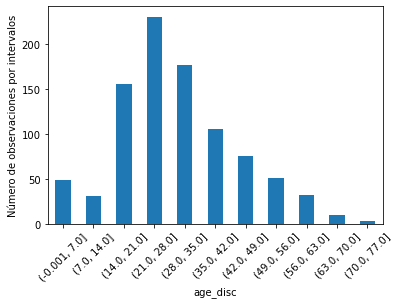

In [47]:
X_train.groupby('age_disc')['age'].count().plot.bar()
plt.xticks(rotation=45)
plt.ylabel('Número de observaciones por intervalos')

La mayoría de los pasajeros del Titanic tenían entre  14-42 años de edad.

Ahora, podemos discretizar la variable age en el set de prueba, usando los mismos límites para los intervalos que calculamos en el set de entrenamiento:

In [48]:
X_test['age_disc_etiquetas'] = pd.cut(x=X_test['age'],
                                   bins=intervals,
                                   labels=labels,
                                   include_lowest=True)

X_test['age_disc'] = pd.cut(x=X_test['age'],
                            bins=intervals,
                            include_lowest=True)

X_test.head()

,age,fare,age_disc_etiquetas,age_disc
1139,38.0,7.8958,Intervalo_6,"(35.0, 42.0]"
533,21.0,21.0000,Intervalo_3,"(14.0, 21.0]"
459,42.0,27.0000,Intervalo_6,"(35.0, 42.0]"
1150,34.0,14.5000,Intervalo_5,"(28.0, 35.0]"
393,25.0,31.5000,Intervalo_4,"(21.0, 28.0]"


Text(0, 0.5, 'Número de observaciones por intervalo')

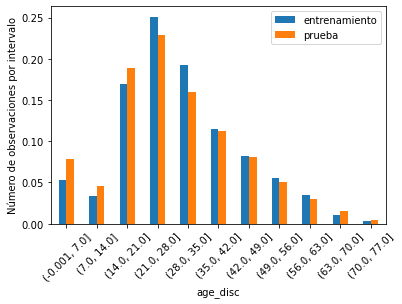

In [49]:
# si las distribuciones de los sets de entrenamiento y prueba son similares,
# deberiamos esperar las mismas proporciones de observaciones 
# en los diferentes intervalos los set de entrenamiento y prueba 
# veamos

t1 = X_train.groupby(['age_disc'])['age'].count() / len(X_train)
t2 = X_test.groupby(['age_disc'])['age'].count() / len(X_test)

tmp = pd.concat([t1, t2], axis=1)
tmp.columns = ['entrenamiento', 'prueba']
tmp.plot.bar()
plt.xticks(rotation=45)
plt.ylabel('Número de observaciones por intervalo')

## Discretización Igual rango con Feature-Engine

In [50]:
# separemos datos en sets de entrenamiento y prueba 
X_train, X_test, y_train, y_test = train_test_split(
    data[['age', 'fare']],
    data['survived'],
    test_size=0.3,
    random_state=0)

X_train.shape, X_test.shape

((916, 2), (393, 2))

In [51]:
# reemplacemos na en ambos sets el de entrenamiento y prueba

X_train['age'] = impute_na(data, 'age')
X_test['age'] = impute_na(data, 'age')

X_train['fare'] = impute_na(data, 'fare')
X_test['fare'] = impute_na(data, 'fare')

In [52]:
# con feature-engine podemos automatizar el proceso de discretización 
# para muchas variables en una línea de código

disc = EqualWidthDiscretiser(bins=10, variables = ['age', 'fare'])

disc.fit(X_train)

EqualWidthDiscretiser(variables=['age', 'fare'])

In [53]:
# en el diccionario del binner, podemos ver los límites de los intervalos.
# Para la variable age el valor incrementa aproximadamente 7 años 
# de un intervalo al siguiente.

# para la variable fare se incrementa 50 dolares de un intervalo al siguiente,
# pero se incrementa siempre con el mismo valor, es decir, el mismo ancho

disc.binner_dict_

{'age': [-inf,
  7.550029999999999,
  14.933359999999999,
  22.316689999999994,
  29.700019999999995,
  37.083349999999996,
  44.46667999999999,
  51.85000999999999,
  59.23333999999999,
  66.61667,
  inf],
 'fare': [-inf,
  51.23292,
  102.46584,
  153.69876,
  204.93168,
  256.1646,
  307.39752,
  358.63044,
  409.86336,
  461.09628,
  inf]}

In [54]:
# transformar los sets de entrenamiento y prueba
train_t = disc.transform(X_train)
test_t = disc.transform(X_test)

In [55]:
train_t.head()

,age,fare
501,1,0
588,0,0
402,4,0
1193,2,0
686,2,0


Text(0, 0.5, 'Proporción de observaciones por intervalo')

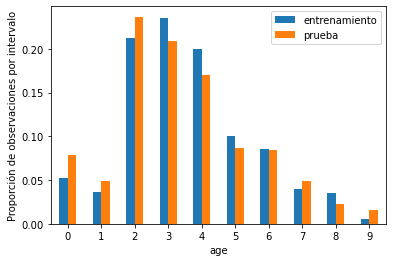

In [56]:
t1 = train_t.groupby(['age'])['age'].count() / len(train_t)
t2 = test_t.groupby(['age'])['age'].count() / len(test_t)

tmp = pd.concat([t1, t2], axis=1)
tmp.columns = ['entrenamiento', 'prueba']
tmp.plot.bar()
plt.xticks(rotation=0)
plt.ylabel('Proporción de observaciones por intervalo')

Text(0, 0.5, 'Proporción de observaciones por intervalo')

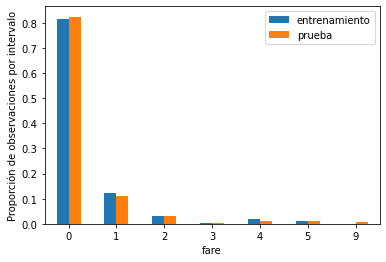

In [57]:
t1 = train_t.groupby(['fare'])['fare'].count() / len(train_t)
t2 = test_t.groupby(['fare'])['fare'].count() / len(test_t)

tmp = pd.concat([t1, t2], axis=1)
tmp.columns = ['entrenamiento', 'prueba']
tmp.plot.bar()
plt.xticks(rotation=0)
plt.ylabel('Proporción de observaciones por intervalo')

Podemos ver que la discretización por igual rango no mejora la distribución de los valores. La variable original fare es sesgada, y la variable discreta también esta sesgada.

## Discretización Igual rango con Scikit-learn

In [58]:
# separemos datos en sets de entrenamiento y prueba 

X_train, X_test, y_train, y_test = train_test_split(
    data[['age', 'fare']],
    data['survived'],
    test_size=0.3,
    random_state=0)

X_train.shape, X_test.shape

((916, 2), (393, 2))

In [59]:
# reemplacemos los na en ambos segmentos

X_train['age'] = impute_na(data, 'age')
X_test['age'] = impute_na(data, 'age')

X_train['fare'] = impute_na(data, 'fare')
X_test['fare'] = impute_na(data, 'fare')

In [60]:
disc = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='uniform')

disc.fit(X_train[['age', 'fare']])

KBinsDiscretizer(encode='ordinal', n_bins=10, strategy='uniform')

In [61]:
disc.bin_edges_

array([array([ 0.1667 ,  7.55003, 14.93336, 22.31669, 29.70002, 37.08335,
       44.46668, 51.85001, 59.23334, 66.61667, 74.     ]),
       array([  0.     ,  51.23292, 102.46584, 153.69876, 204.93168, 256.1646 ,
       307.39752, 358.63044, 409.86336, 461.09628, 512.3292 ])],
      dtype=object)

In [62]:
train_t = disc.transform(X_train[['age', 'fare']])

train_t = pd.DataFrame(train_t, columns = ['age', 'fare'])

train_t.head()

,age,fare
0,1.0,0.0
1,0.0,0.0
2,4.0,0.0
3,2.0,0.0
4,2.0,0.0


In [63]:
test_t = disc.transform(X_test[['age', 'fare']])

test_t = pd.DataFrame(test_t, columns = ['age', 'fare'])

Text(0, 0.5, 'Número de observaciones por intervalo')

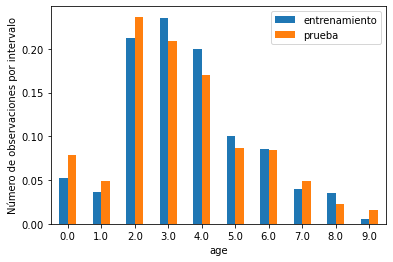

In [64]:
t1 = train_t.groupby(['age'])['age'].count() / len(train_t)
t2 = test_t.groupby(['age'])['age'].count() / len(test_t)

tmp = pd.concat([t1, t2], axis=1)
tmp.columns = ['entrenamiento', 'prueba']
tmp.plot.bar()
plt.xticks(rotation=0)
plt.ylabel('Número de observaciones por intervalo')


Text(0, 0.5, 'Número de observaciones por intervalo')

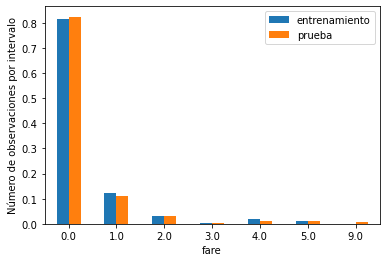

In [65]:
t1 = train_t.groupby(['fare'])['fare'].count() / len(train_t)
t2 = test_t.groupby(['fare'])['fare'].count() / len(test_t)

tmp = pd.concat([t1, t2], axis=1)
tmp.columns = ['entrenamiento', 'prueba']
tmp.plot.bar()
plt.xticks(rotation=0)
plt.ylabel('Número de observaciones por intervalo')